In [ ]:
# Clone the entire repo.
!git clone -l -s git://github.com/RobbieHolland/AIWire.git
%cd AIWire
!ls

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
import sys
sys.path.append("../") # go to parent dir
sys.path.append("../extract_centerline/")
sys.path.append("../extract_centerline/bin/")
sys.path.append("util/")
!ls

classical_segmentation.ipynb  Segnet.py
dataset.py		      SegNet_segmentation.ipynb
load_data.py		      Unet_pytorch.py
logs			      UNet_segmentation.ipynb
__pycache__		      util
saved_models


In [2]:
# Import libraries 
import time
import torch
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
import numpy as np
from tqdm.notebook import tqdm
import wireskeletonise 
from PIL import Image
import subprocess 
from centerline_extraction import * 

# Use full browser width
from IPython.core.display import display, HTML
display(HTML(""))

In [3]:
def show_images(outputs, coords=None, height=10, title='', n=10):
    fig = plt.figure(figsize=[height, 3])
    for i, output in enumerate(outputs[:n]):
        plt.subplot(1,n,i+1)
        plt.axis('off')
        plt.imshow(output, cmap='gray')
        if coords: 
            colors = cm.rainbow(np.linspace(0, 1, len(coords)))
            for pts,c in zip(coords,colors):
                plt.scatter(pts[len(pts)-1,0],pts[len(pts)-1,1],color=c)
        plt.title(title)
    plt.show()

# (Option 1) Generate data
Run the Matlab engine to call scripts that generate data

In [4]:
# python -m ipykernel install --user --name=my-virtualenv-name
import matlab.engine

# Show data
eng_start = time.time()
eng = matlab.engine.start_matlab()
print('Engine start took', time.time() - eng_start, 'seconds')

import pathlib
import os
_ = eng.addpath(os.path.join(str(pathlib.Path().absolute().parents[0]), 'simulation'))
_ = eng.addpath(os.path.join(str(pathlib.Path().absolute().parents[0]), 'simulation/util'))

Engine start took 4.641338348388672 seconds


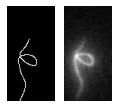

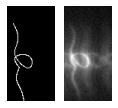

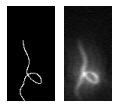

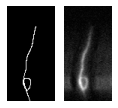

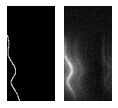

Simulation took 2.72363018989563 seconds


In [5]:
data = []

blur = 1.3
im_size = eng.cell2mat([128.0, 64.0])
sim_start = time.time()
for i in range(5):
#     pts, _ = eng.gen_spline_realistic(im_size, 100.0, 0.75, nargout = 2)
    pts, _ = eng.gen_spline_realistic(im_size, 100.0, 0.75, nargout = 2)
    ground_truth, simulated = eng.simulate(pts, im_size, 1.3, 1.0, 1.3, 10.0, 0.2, 0, 0, nargout=2)
    show_images([ground_truth, simulated])
    
# Most of the time is to set up the connection
print('Simulation took', time.time() - sim_start, 'seconds')

# (Option 2) Load data
Load data saved in a <tt>.mat</tt> file

In [6]:
from load_data import *
# X, y = load_data('/content/drive/My Drive/AIWIRE', 'dataset')
X, y, pts = load_data('.', '../data/toy_dataset', spline_pts = True)

In [7]:
import dataset
from sklearn.model_selection import train_test_split

batch_size = 5
test_length = round(y.shape[0] * 0.2)
pts = pts[:, :, ::-1]
X_train, y_train, X_test, y_test = X[:-test_length], y[:-test_length], X[-test_length:], y[-test_length:]
pts_train, pts_test = pts[:-test_length], pts[-test_length:]
dataloaders = dataset.gen_dataloaders(X_train, X_test, y_train, y_test, batch_size)

{'train': 1600, 'val': 400}


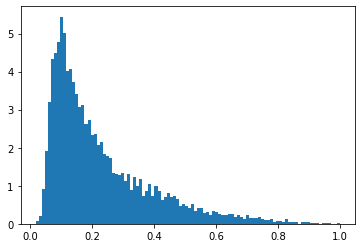

In [8]:
# Look at statistics of data
h2 = plt.hist(X_train[0].reshape(-1,1), bins = 100, density = True, alpha=1)

# Intensity-based Segmentation
Here, we use a Laplace filter to do a basic intensity based segmentation

In [9]:
# Segment data
from sklearn.mixture import GaussianMixture
import cv2

# The background and the wire
n_components = 2

# model=GaussianMixture(n_components=n_components, means_init=[[0], [0.6]])
# model.fit(X, y)

def laplace_segmentation(image, threshold = 0.52):
    lp = -cv2.Laplacian(image, cv2.CV_64F, ksize=15)
    lp = lp - np.min(lp)
    lp = lp / np.max(lp)
    return lp > threshold

In [10]:
def get_centerline(img,directory,name): 
    img = img.astype(np.float32)
    os.chdir("../")
    file_dir = os.getcwd() + '/extract_centerline/example/'
    wireskeletonise.preAmbrosini(img, file_dir+name)
    os.chdir(file_dir)
    result = subprocess.call(['sh','./extract_centerline.sh'])
    pt_list = PtsListFromFile(file_dir + name + '.txt')
    pts = np.array(pt_list)
    centerline = np.zeros_like(img)
    for ww in range(len(pts)):
        if int(pts[ww,1]) < centerline.shape[0] and int(pts[ww,0])< centerline.shape[1]:
            centerline[int(pts[ww,1]),int(pts[ww,0])] = 1
    os.chdir(directory)
    return centerline, pts

/home/mmu18/Desktop/Projects/AIWire/segmentation
/home/mmu18/Desktop/Projects/AIWire/segmentation


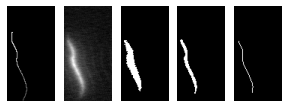

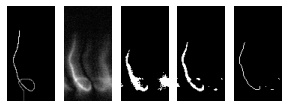

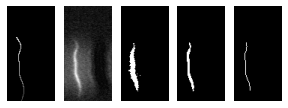

In [14]:
%cd ../segmentation
original_dir= os.getcwd()
print(original_dir)

# Show first few segmentations
for i, (ground_truth, simulated, gt_pts) in enumerate(list(zip(y_test, X_test, pts_test))[:3]):
    centerline, cl_pts = get_centerline(laplace_segmentation(simulated),original_dir,'binary')
    show_images([ground_truth, simulated, simulated > 0.45, laplace_segmentation(simulated),centerline])

# Random Forest Segmentation
This is the first machine learning method we are using.


### Create the dataset
Random forests predict each patch of the image by taking as input a larger, surrounding patch (to capture context)<br>
Thus, <br>
<b>y</b>: Patches of the image <br>
<b>X</b>: Larger patches centered over each <b>y</b>

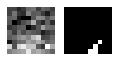

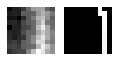

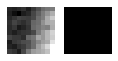

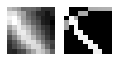

5
[5]


In [15]:
from random import randint

n_patches = 2000
patch_dim = 10
patches_sim, patches_gt = [], []
for i in range(n_patches):
    sample_train = X_train[i % len(X_train)]
    sample_test  = y_train[i % len(y_train)]
    tl = np.array([randint(0, sample_train.shape[i] - patch_dim - 1) for i in [0, 1]])
    patches_sim.append(sample_train[tl[0]:tl[0] + patch_dim, tl[1]:tl[1] + patch_dim])
    patches_gt.append(sample_test[tl[0]:tl[0] + patch_dim, tl[1]:tl[1] + patch_dim])

for i, (patch_sim, patch_gt) in enumerate(list(zip(patches_sim, patches_gt))[:4]):
    show_images([patch_sim, patch_gt])
    
patches_sim, patches_gt = np.array(patches_sim), np.array(patches_gt)
w = 0
c = patch_dim // 2
print(c)
print(list(range(c-w,c+w+1)))
patch_labels = np.array([p[c - w:c + w + 1, c - w:c + w + 1] for p in patches_gt])
X_patches = np.array(patches_sim).reshape(n_patches,-1)
y_patches = np.array(patch_labels).reshape(n_patches,-1)

### Train random forest classifier

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

print('Class balance: ', np.sum(patch_labels) / np.prod(patch_labels.shape))
# clf = RandomForestClassifier(max_depth=100)

X_patches_train, X_patches_test, y_patches_train, y_patches_test = train_test_split(X_patches, y_patches, test_size=0.15, random_state=0)
print(X_patches_train.shape, X_patches_test.shape, y_patches_train.shape, y_patches_test.shape)

#clf = RandomForestClassifier(max_depth=100, class_weight = [{0: 1, 1:50}] * y_patches_train.shape[-1])
clf = RandomForestClassifier(max_depth=100, class_weight = {0: 1, 1:50})
clf.fit(X_patches_train, y_patches_train.astype(bool).ravel())
preds = clf.predict(X_patches_test)

Class balance:  0.011211322645290579
(1700, 100) (300, 100) (1700, 1) (300, 1)


### Make prediction on image
To actually segment an image, we must do so patch-by-patch<br>
Then collect the patches into the final segmentation

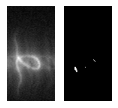

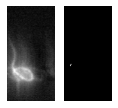

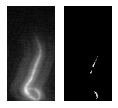

In [17]:
def rf_segmentation(image):
    test_sample = np.array(image)
    sample = np.pad(test_sample, patch_dim // 2 - w, mode='reflect')
    
    total_pred = np.zeros_like(test_sample)
    for i in range(w, test_sample.shape[0] - 2*w, 2 * w + 1):
        for j in range(w, test_sample.shape[1] - 2*w, 2 * w + 1):
            patch = sample[i:i + patch_dim, j:j + patch_dim]
            pred = clf.predict(patch.reshape(1,-1))
            total_pred[i-w:i+w+1,j-w:j+w+1] = pred.reshape(2 * w + 1, 2 * w + 1)
    return total_pred

for i in range(3):
    pred = rf_segmentation(X[i])
    show_images([X[i], pred])

# Evaluation
pts, im_size, blur, thickness, ...
   undersampling, undersampling_spread, tip_current, length_regression, verbose

In [18]:
# Load UNet & SegNet
save_path = 'saved_models/'

import Unet_pytorch
import Segnet
num_class = 1
Unet_model = Unet_pytorch.UNet(num_class)
Segnet_model = Segnet.SegNet(num_class)
device = torch.device("cuda: 0" if torch.cuda.is_available() else "cpu")
Unet_model.load_state_dict(torch.load(save_path+'model_thin', map_location=device))
Segnet_model.load_state_dict(torch.load(save_path+'segnet_model_thin.pth', map_location=device))
print("Using", device)
Unet_model = Unet_model.to(device)
Segnet_model = Segnet_model.to(device)

dataloaders = dataset.gen_dataloaders(X_train, X_test, y_train, y_test, batch_size)

Using cpu
{'train': 1600, 'val': 400}


In [20]:
import metrics
HAUS_D = metrics.hausdorff_distance
MSE = metrics.MSE 
TIP_D = metrics.tip_distance  


In [22]:
def evaluate_method(method, metric, n = None):
    metrics = []
    for i, (simulated, ground_truth) in tqdm(enumerate(dataloaders['val'])):
        if n is not None and i >= n:
            break
        segmented = method(simulated.float().squeeze(1).detach().numpy())
        metrics.append(metric(segmented, ground_truth.numpy()))
    return np.array(metrics).mean()

In [23]:
methods = {'Laplace filter': lambda x: np.array([laplace_segmentation(x_i) for x_i in x]),
           'Random forest': lambda x: np.array([rf_segmentation(x_i) for x_i in x]),
           'UNet': lambda x: Unet_model((torch.Tensor(x).unsqueeze(1).to(device))).detach().cpu().numpy(),
           'SegNet': lambda x: Segnet_model((torch.Tensor(x).unsqueeze(1).to(device))).detach().cpu().numpy()}

#for name, method in methods.items():
#    score = evaluate_method(method, MSE, n = 20).mean()
#    print(f'{name} had MSE of {score}')


## Ablation study

Varying Tip current...


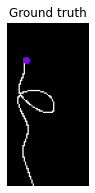

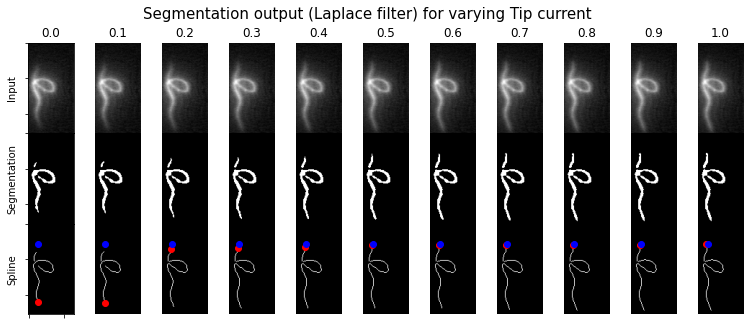

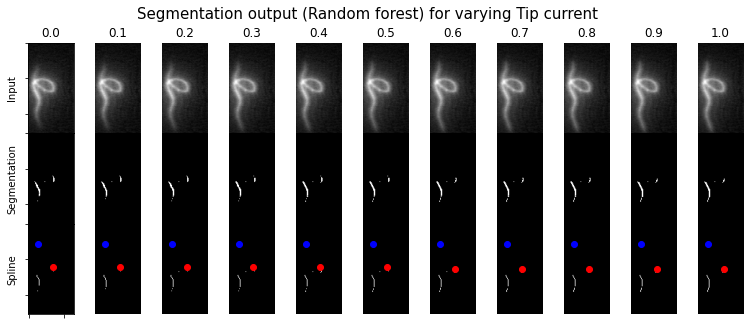

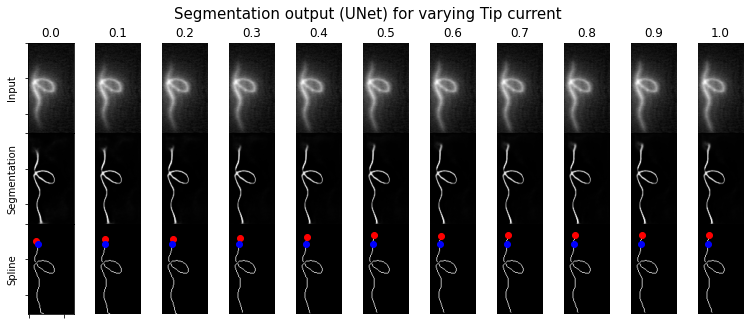

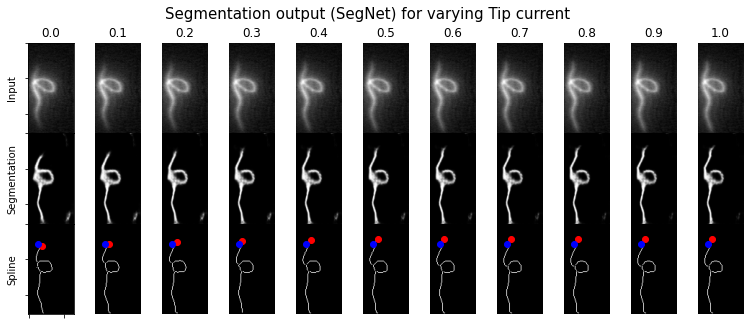

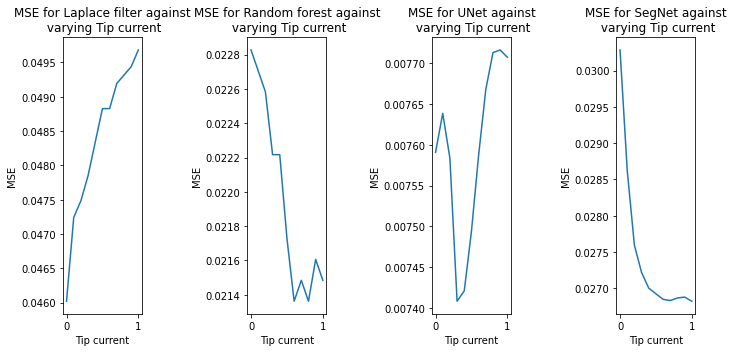

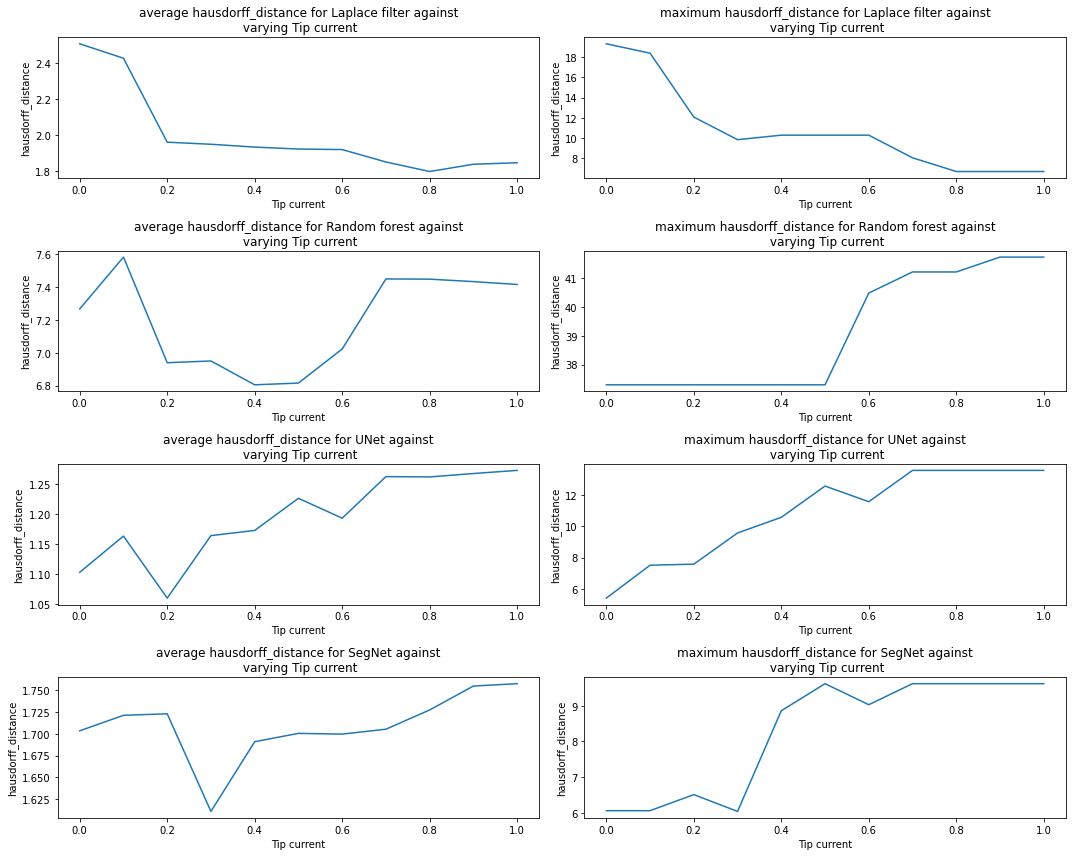

Evaluation took 598.1387708187103 seconds
Varying Undersampling factor...


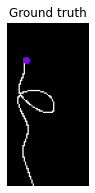

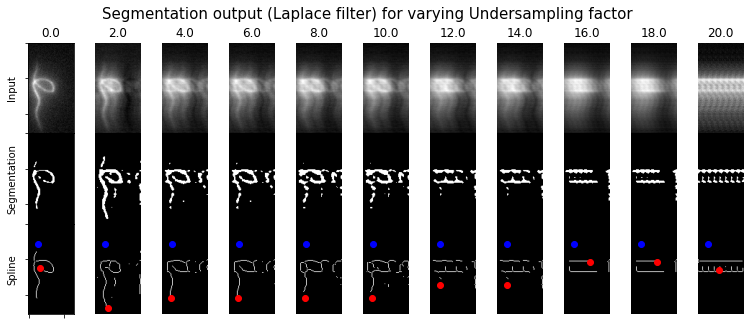

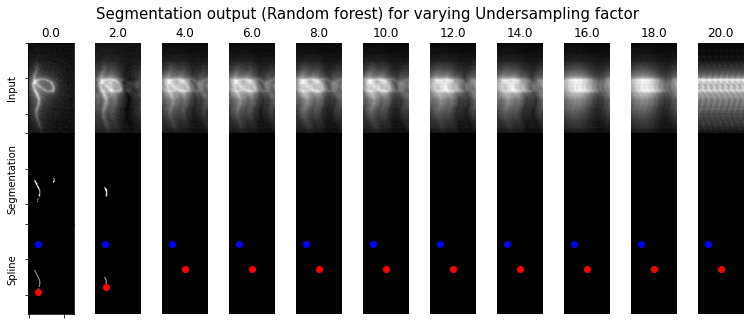

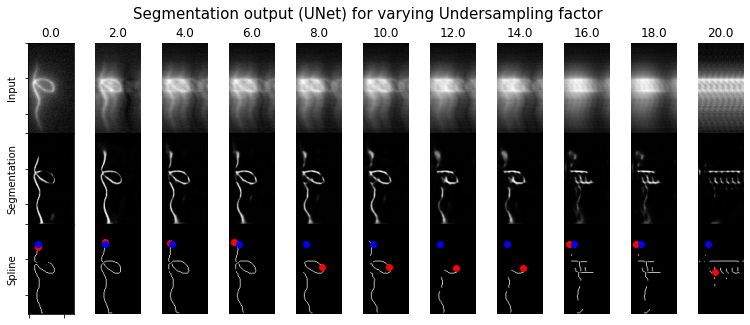

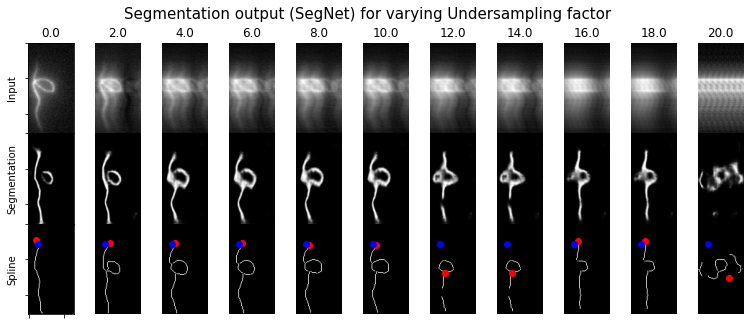

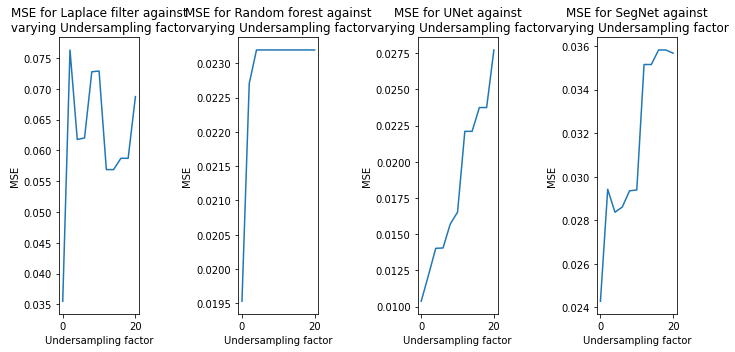

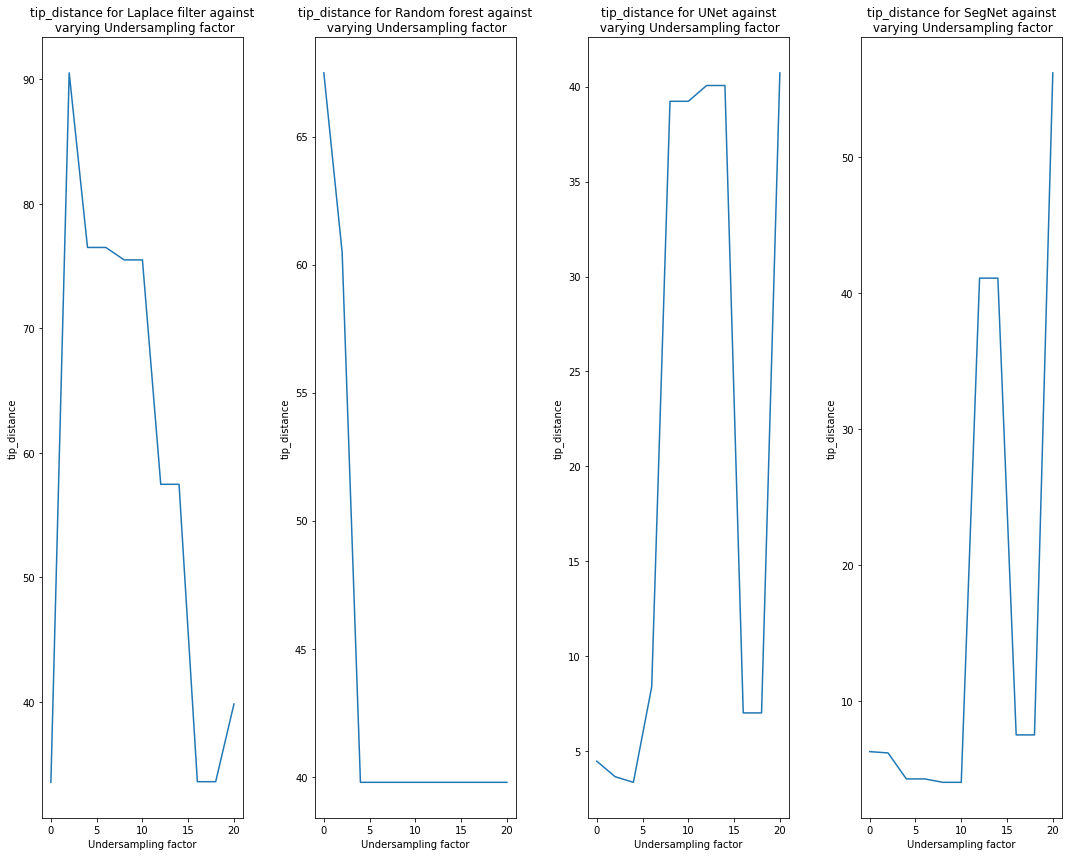

Evaluation took 589.8709049224854 seconds


In [25]:
im_size = eng.cell2mat([128.0, 64.0])
eng.addpath('util/')

def evaluate_ablation(methods, metric, spline_metric, parameters, loop_prob = 1, rng=1235):
    eng.rng(rng)
    pts, _ = eng.gen_spline_realistic(im_size, 100.0, loop_prob, nargout = 2)
    gt_pts = np.array(pts._data).reshape(pts.size, order='F').T 
    gt_pts = gt_pts[:,1:]
    gt_pts[:,[0, 1]] = gt_pts[:,[1, 0]]
    
    variants = [v for v in parameters.keys() if len(np.unique(parameters[v])) > 1]
    if len(variants) != 1:
        print(f'Warning, varying {len(variants)} parameter(s)')
    variant = variants[0]
    print(f'Varying {variant}...')
    n_values = len(parameters[variant])
    
    # Simulate the images for varying parameter
    sim_start = time.time()
    simulated_images, ground_truths = [], []
    for b, u, us, tc in np.array(list(parameters.values())).T.tolist():
        eng.rng(rng)
        ground_truth, simulated = np.array(eng.simulate(pts, im_size, b, 1.0, u, us, tc, 0, 0, nargout=2))
        simulated_images.append(simulated)
        ground_truths.append(ground_truth)

    # Segment using every method
    simulated_images, ground_truths = np.array(simulated_images), np.array(ground_truths)
    segmented, scores, scores_spline, centerlines, splines = {}, {}, {}, {}, {}
    for name, method in methods.items():
        segmented[name] = method(simulated_images)
        scores[name] = metric(segmented[name], ground_truths)
        score_spline = np.array([])
        all_centerline, all_cl_pts = [],[]
        for v in segmented[name]:
            v = np.squeeze(v)
            if not isinstance(v,bool):
                v = v>0.2
            centerline, cl_pts = get_centerline(v,original_dir,'binary')
            cl_pts = np.flip(cl_pts,axis=0)
            score_spline = np.append(score_spline,spline_metric(gt_pts, cl_pts))
            all_centerline.append(centerline)
            all_cl_pts.append(cl_pts)
        scores_spline[name] = score_spline      
        centerlines[name] = np.array(all_centerline)
        splines[name] = np.array(all_cl_pts)
 
    show_images([ground_truths[0]], title = 'Ground truth', height = 20, coords=[gt_pts])
    for i, method in enumerate(methods.keys()):
        fig = plt.figure(figsize=[20, 5])
        fig.suptitle(f'Segmentation output ({method}) for varying {variant}\n', fontsize=15)
        ax = [plt.subplot(3,n_values,i+1) for i in range(3 * n_values)]
        for i, (v, sim, out, lin, pts) in enumerate(zip(parameters[variant], simulated_images, segmented[method], centerlines[method], splines[method])):
            ax[i].imshow(sim, cmap='gray')
            ax[i].axis('off')
            ax[i].set_title(round(v, 2))
            ax[i + n_values].axis('off')
            try:
                ax[i + n_values].imshow(out.squeeze(0), cmap='gray')
            except:
                ax[i + n_values].imshow(out,cmap='gray')
            ax[i + n_values*2].axis('off')
            ax[i + n_values*2].imshow(lin, cmap='gray')
            ax[i + n_values*2].scatter(pts[len(pts)-1,0],pts[len(pts)-1,1],color='r')
            ax[i + n_values*2].scatter(gt_pts[len(gt_pts)-1,0],gt_pts[len(gt_pts)-1,1], color='b')
        ax[0].axis('on')
        ax[0].set_yticklabels([])
        ax[0].set_xticklabels([])
        ax[0].set_ylabel('Input')
        ax[n_values].axis('on')
        ax[n_values].set_yticklabels([])
        ax[n_values].set_xticklabels([])
        ax[n_values].set_ylabel('Segmentation')
        ax[n_values*2].axis('on')
        ax[n_values*2].set_yticklabels([])
        ax[n_values*2].set_xticklabels([])
        ax[n_values*2].set_ylabel('Spline')
        plt.subplots_adjust(wspace=-0.85, hspace=-0)
        plt.show()

    # Plotting performance of the metric against the changing parameter
    fig = plt.figure(figsize=[10, 5])
    for i, method in enumerate(methods.keys()):
        plt.subplot(1,len(methods),i+1)
        plt.plot(parameters[variant], scores[method], label = method)
        plt.title(f'{metric.__name__} for {method} against\n varying {variant}')
        plt.xlabel(variant)
        plt.ylabel(metric.__name__)
    plt.tight_layout()
    plt.show()

    # Plotting performance of the metric against the changing parameter
    fig = plt.figure(figsize=[15, 12])
    for i, method in enumerate(methods.keys()):
        if isinstance(scores_spline[method][0],dict): 
            count = 1
            for k,v in scores_spline[method][0].items():
                all_values = np.array([])
                for dic in scores_spline[method]:
                    all_values = np.append(all_values,dic[k])
                plt.subplot(len(methods),len(scores_spline[method][0].items()),count+2*i)
                plt.plot(parameters[variant], all_values, label = method)
                plt.title(f'{(" ".join([k, spline_metric.__name__]))} for {method} against\n varying {variant}')
                plt.xlabel(variant)
                plt.ylabel(spline_metric.__name__)
                plt.tight_layout()
                count+=1
        else:
            plt.subplot(1,len(methods),i+1)
            plt.plot(parameters[variant], scores_spline[method], label = method)
            plt.title(f'{spline_metric.__name__} for {method} against\n varying {variant}')
            plt.xlabel(variant)
            plt.ylabel(spline_metric.__name__)
    plt.tight_layout()
    plt.show()
    print('Evaluation took', time.time() - sim_start, 'seconds')

n_values = 11
def_parameters = {}
def_parameters['Blur'] = [1.3] * n_values
def_parameters['Undersampling factor'] = [1.3] * n_values
def_parameters['Undersampling spread'] = [10.0] * n_values
def_parameters['Tip current'] = [0.2] * n_values

# Change parameter to vary
parameters = def_parameters.copy()
parameters['Tip current'] = np.linspace(0, 1, num=n_values).tolist()
evaluate_ablation(methods, MSE, HAUS_D, parameters, rng = 1238)

parameters = def_parameters.copy()
parameters['Undersampling factor'] = np.linspace(0.001, 20, num=n_values).tolist()
evaluate_ablation(methods, MSE, TIP_D, parameters, rng = 1238)
